In [ ]:
%logstop
%logstart -ortq ~/.logs/ML_FeatureEngineering.py append
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Feature engineering

<!-- requirement: data/land_temps_by_city.csv -->

Our models can't reveal structure in our data when no structure exists.

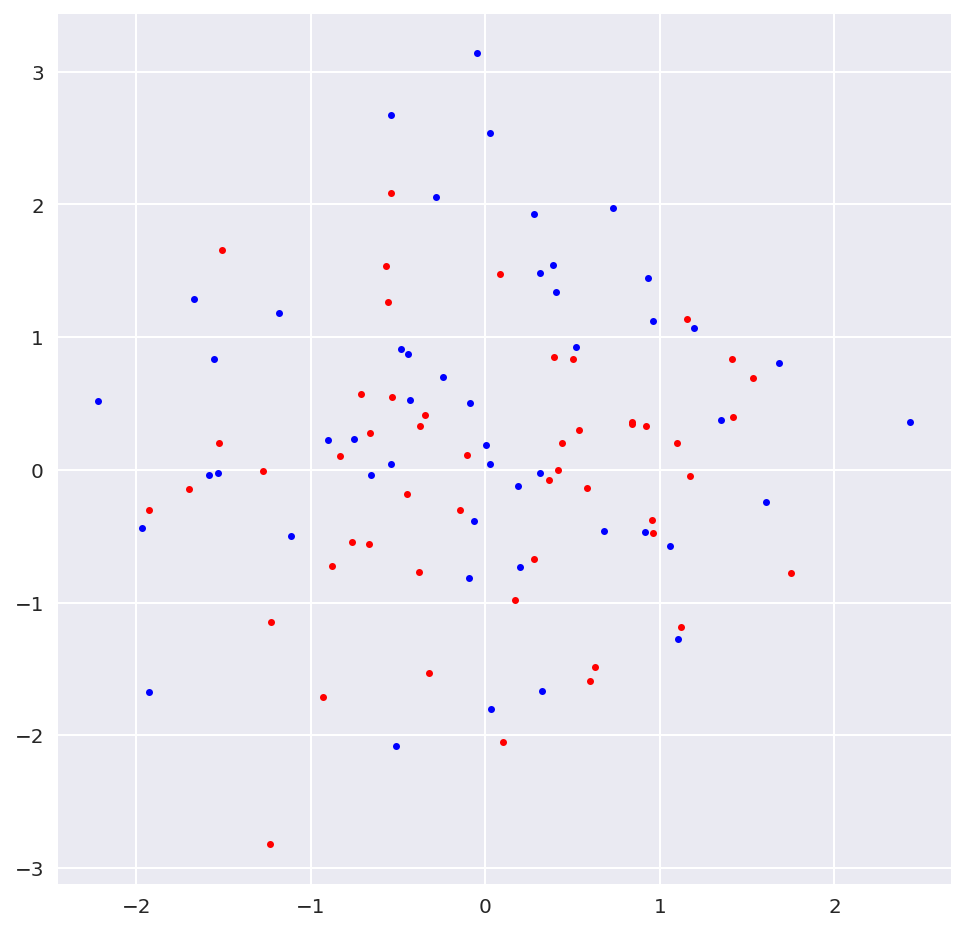

In [4]:
x1 = np.random.randn(100)
x2 = np.random.randn(100)
y = np.random.choice([True, False], size=100)

plt.figure(figsize=(8,8))
plt.plot(x1[y], x2[y], 'b.')
plt.plot(x1[~y], x2[~y], 'r.');

In [5]:
random_df = pd.DataFrame(np.vstack([x1, x2, y]).T, columns=['x1', 'x2', 'y'])
random_df.head()

,x1,x2,y
0,-0.534703,0.547812,0.0
1,-1.967318,-0.434592,1.0
2,-0.088218,0.507716,1.0
3,-0.482443,0.914689,1.0
4,-0.048413,3.138788,1.0


In [6]:
random_df.corr()

,x1,x2,y
x1,1.000000,0.060817,-0.034670
x2,0.060817,1.000000,0.215062
y,-0.034670,0.215062,1.000000


Beyond the choice of features to measure and how much data to collect (which we often can't control), there are many techniques for transforming our data set to amplify the most useful information for our machine learning models. Some of these techniques operate on the data directly while others are modifications to how we train our estimator. Such techniques are collectively called feature engineering.

## Feature extraction

Machine learning algorithm require observations to be vectors of features. Sometimes our raw data will not be a vector of features or a vector at all. For example, our data might be a collection of images. We could flatten the image into a vector, but this destroys important spatial relationships in the data. Our data could be a string of text like a news article. A string is linear, but doesn't have fixed length, and it's not immediately clear how to represent text as numbers. Our data could be several years of commodity price data, which is a vector of numbers, but it may be better represented in an aggregated form instead of a raw time-series.

In cases like these we have the privilege of constructing features, giving us maximum control over preparation of the data (without actually deciding how raw data gets collected). Feature extraction will often be specific to the data set, but some things to think about include:

- What counts as an observation in the raw data?
- Are there spatial or temporal relationships within the data of a single observation?
- If my data aren't numbers, what is the most meaningful way to transform the data into numbers?
- If my data are numbers, are the raw values most meaningful? Differences between raw values? Other transformations or aggregations?

Let's work through an example to illustrate some of these concepts.

In [7]:
temps = pd.read_csv('./data/land_temps_by_city.csv', parse_dates=[0])
temps.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1900-02-01,0.969,0.585,Berlin,Germany,52.24N,13.14E
1,1900-03-01,1.313,0.328,Berlin,Germany,52.24N,13.14E
2,1900-04-01,7.246,0.317,Berlin,Germany,52.24N,13.14E
3,1900-05-01,12.125,0.240,Berlin,Germany,52.24N,13.14E
4,1900-06-01,17.362,0.343,Berlin,Germany,52.24N,13.14E


We have temperature data for many cities around the world. If we were making predictions about the climate of these different cities, it may be more useful to summarize the temperature data in a quantity that characterizes the different climates. For example, some of these cities have 4 seasons while others do not. We might see this reflected in how the temperatures correlate with each other over the course of the year.

In [8]:
from functools import reduce
def collect(x):
    return reduce(lambda y, z: y + [z] if isinstance(y, list) else [z], x)

def estimated_autocorrelation(x):
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

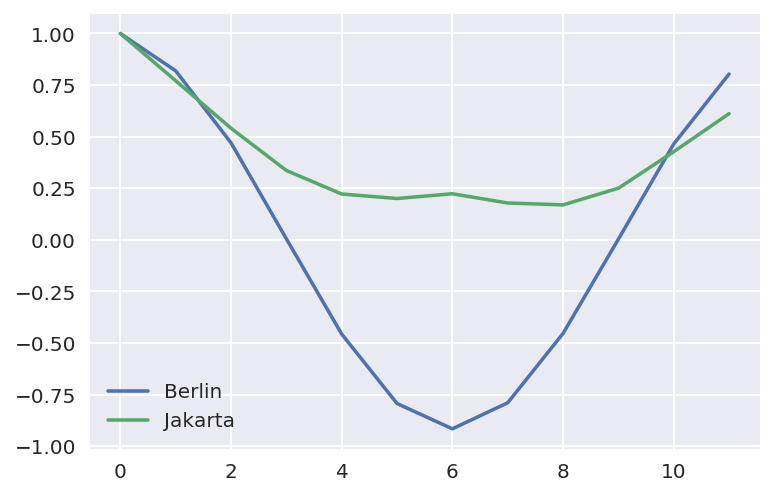

In [9]:
plt.plot(estimated_autocorrelation(temps[temps['City']=='Berlin']['AverageTemperature'].values)[:12], label='Berlin')
plt.plot(estimated_autocorrelation(temps[temps['City']=='Jakarta']['AverageTemperature'].values)[:12], label='Jakarta')
plt.legend();

Looking at these graphs, we can see that the temperature in Berlin six months in the future mirrors the temperature in Berlin today (correlation $\approx$ -1). However, in Jakarta, the average temperature six months in the future is basically unrelated to the temperature today (correlation $\approx$ 0). This indicates a different seasonality, associated with their different climates. We can extract the six-month autocorrelation value as a feature for each city's climate.

In [10]:
ac = temps.groupby('City')['AverageTemperature'].apply(collect).apply(lambda x: np.array(x)).apply(estimated_autocorrelation).rename('autocorr')
ac_lat = pd.concat([ac.apply(lambda x: x[range(6, 1362, 12)].mean()), temps[['City', 'Latitude']].drop_duplicates().set_index('City')], axis=1)
ac_lat['Latitude'] = ac_lat['Latitude'].apply(lambda x: float(x[:-1]))

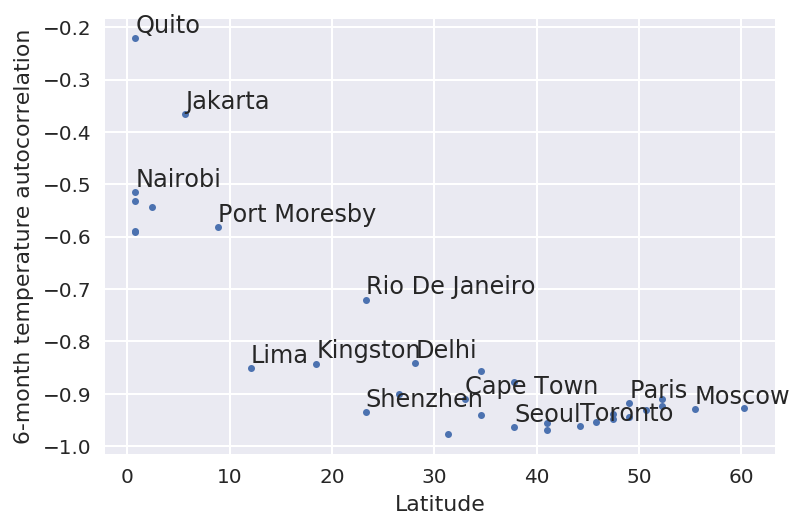

In [11]:
plt.plot(ac_lat['Latitude'], ac_lat['autocorr'], '.')
plt.xlabel('Latitude')
plt.ylabel('6-month temperature autocorrelation');

ax = plt.gca()
labels = {'Lima', 'Shenzhen', 'Delhi', 'Lima', 'Kingston', 'Cape Town', 'Jakarta', 'Nairobi', 'Rio De Janeiro', 'Quito', 'Port Moresby', 'Seoul', 'Moscow', 'Paris', 'Toronto'}
for city in ac_lat.index:
    if city in labels:
        plt.text(ac_lat.loc[city, 'Latitude'], ac_lat.loc[city, 'autocorr'] + .01, city)

## Feature transformations

Sometimes our observations will be very unevenly distributed for a given feature. For example, income is roughly exponentially distributed in many populations. Sometimes the relationship between a feature and a regression target follows a clear non-linear trend. In cases like these it can be useful to transform the values of our features or our target to better highlight trends or to allow for use of models that might not otherwise be applicable.

For example, we could fit a line to the relationship between latitude and 6-month autocorrelation in temperature, but it wouldn't be a great fit.

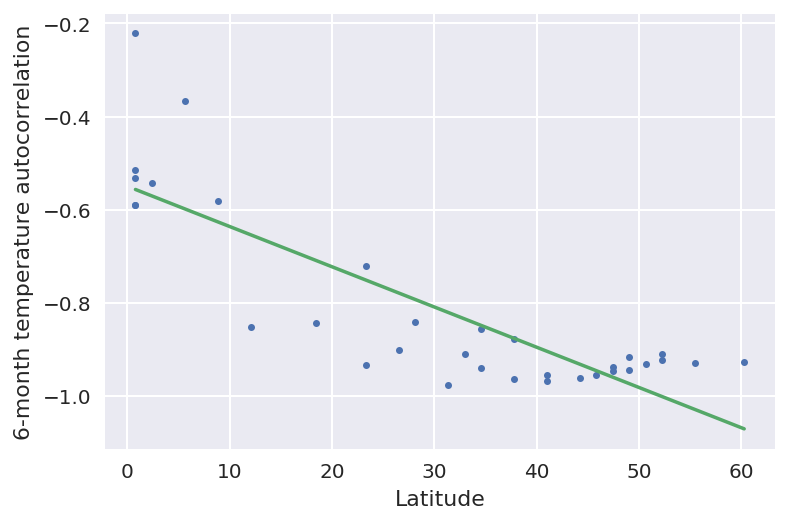

In [12]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression().fit(ac_lat['Latitude'].values.reshape(-1, 1), ac_lat['autocorr'].values.reshape(-1, 1))

ac_lat.sort_values('Latitude', inplace=True)

plt.plot(ac_lat['Latitude'], ac_lat['autocorr'], '.')
plt.plot(ac_lat['Latitude'], lin_reg.predict(ac_lat['Latitude'].values.reshape(-1, 1)))
plt.xlabel("Latitude")
plt.ylabel('6-month temperature autocorrelation');

However, this data looks roughly like $y = e^{-x/\lambda} - 1$. If we substituted the variable $u = e^{-x/\lambda}$, we would have $y \propto u$, a linear relationship.

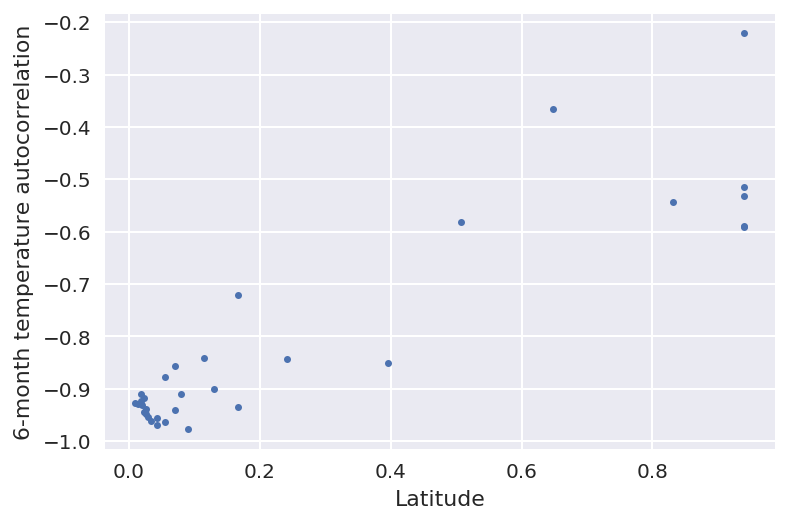

In [13]:
plt.plot(np.exp(-ac_lat['Latitude']/13), ac_lat['autocorr'], '.')
plt.xlabel('Latitude')
plt.ylabel('6-month temperature autocorrelation');

This looks somewhat more linear. We could fit a linear model to this transformed feature.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.utils import shuffle

X_train, X_test, y_train, y_test = train_test_split(*shuffle(ac_lat['Latitude'].values.reshape(-1, 1), ac_lat['autocorr'].values.reshape(-1, 1)), test_size=0.1)

lin_reg = LinearRegression()

lin_reg.fit(np.exp(-X_train/13), y_train)

lin_pred = lin_reg.predict(np.exp(-X_test/13))

Let's compare the result with a decision tree applied to the untransformed data.

In [15]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=3)
tree_reg.fit(X_train, y_train)
tree_pred = tree_reg.predict(X_test)

Transformed linear regression: 0.02
Decision tree regression: 0.03


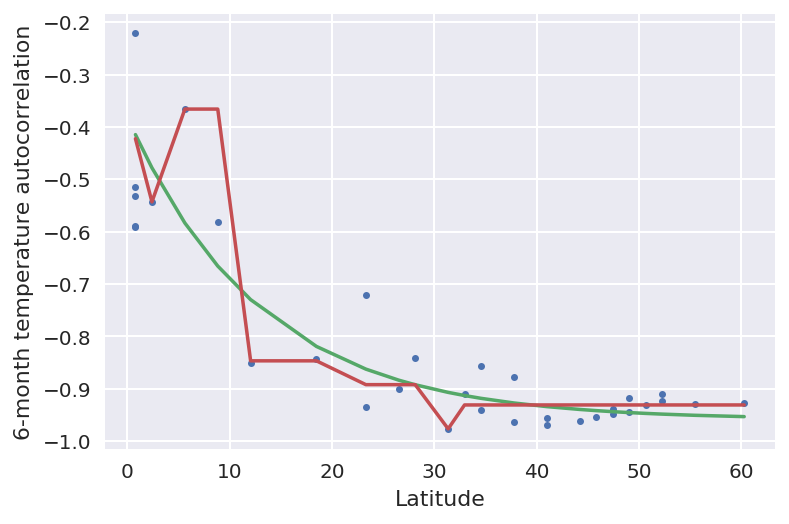

In [16]:
ac_lat.sort_values('Latitude', inplace=True)

plt.plot(ac_lat['Latitude'], ac_lat['autocorr'], '.', label='data')
plt.plot(ac_lat['Latitude'], lin_reg.predict(np.exp(-ac_lat['Latitude'].values.reshape(-1, 1) / 13)))
plt.plot(ac_lat['Latitude'], tree_reg.predict(ac_lat['Latitude'].values.reshape(-1, 1)))
plt.xlabel('Latitude')
plt.ylabel('6-month temperature autocorrelation');

print('Transformed linear regression: %0.2f' % mse(y_test, lin_pred))
print('Decision tree regression: %0.2f' % mse(y_test, tree_pred))

## Curse of dimensionality

It is easy to see why adding features to a data set might be helpful.

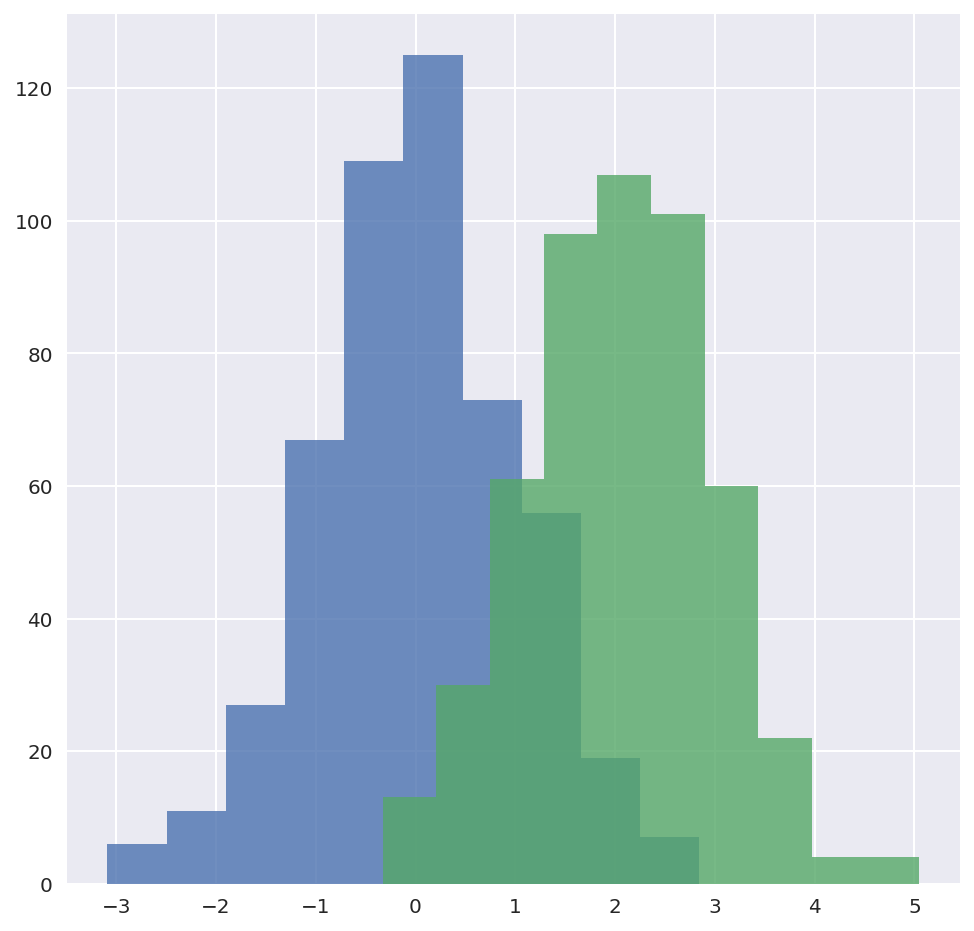

In [17]:
n = 1000
x1 = np.concatenate([np.random.randn(n // 2), np.random.randn(n // 2) + 2])
y = np.array([True if i < n // 2 else False for i in range(n)])

plt.figure(figsize=(8,8))
plt.hist(x1[y], alpha=.8)
plt.hist(x1[~y], alpha=.8);

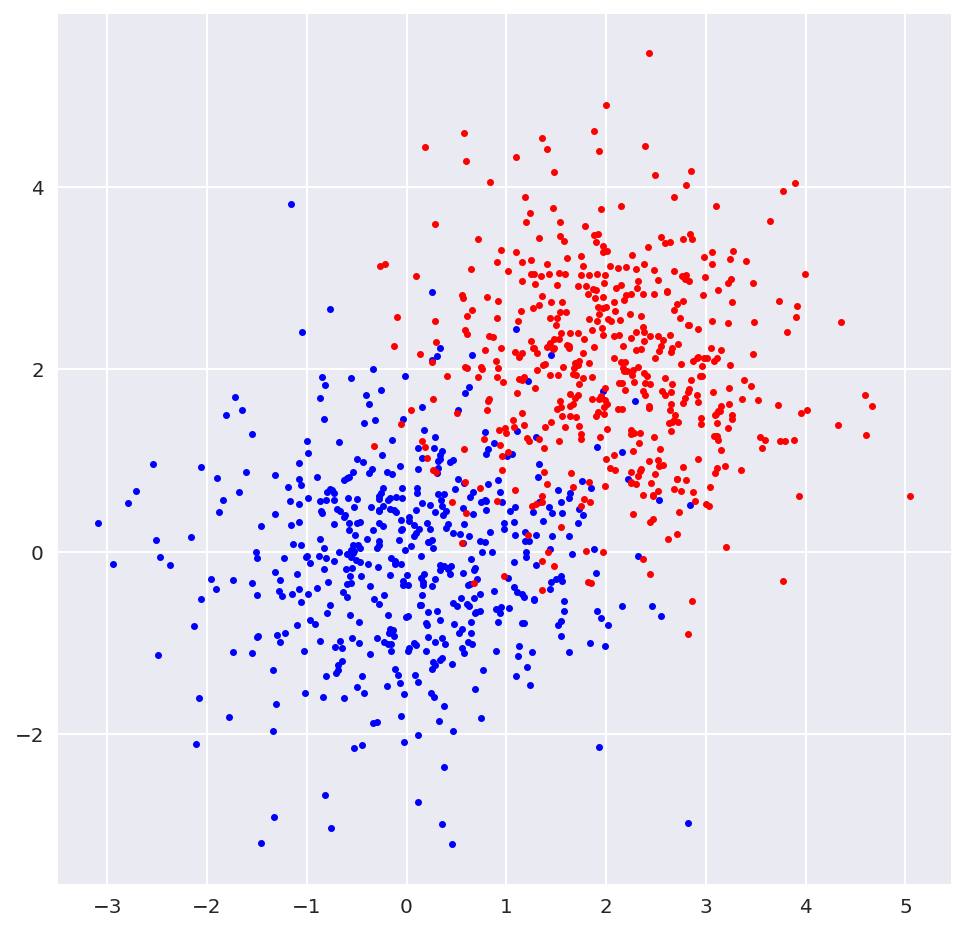

In [18]:
x2 = np.concatenate([np.random.randn(n // 2), np.random.randn(n // 2) + 2])

plt.figure(figsize=(8,8))
plt.plot(x1[y], x2[y], 'b.')
plt.plot(x1[~y], x2[~y], 'r.');

In [19]:
np.vstack([x1, x2]).T

array([[-0.2366846 ,  0.69805697],
       [-0.86668864,  0.55697371],
       [-0.33882646,  0.2361415 ],
       ...,
       [ 2.80236468,  3.02774677],
       [ 1.50589913,  2.56582517],
       [ 3.23185009,  1.79278364]])

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(np.vstack([x1, x2]).T, y)

log_reg_1d = LogisticRegression(solver='lbfgs').fit(np.atleast_2d(X_train[:, 0]).T, y_train)

log_reg_2d = LogisticRegression(solver='lbfgs').fit(X_train, y_train)

print('Score on 1D data: %0.2f' % accuracy_score(y_test, log_reg_1d.predict(np.atleast_2d(X_test[:, 0]).T)))
print('Score on 2D data: %0.2f' % accuracy_score(y_test, log_reg_2d.predict(X_test)))

Score on 1D data: 0.83
Score on 2D data: 0.92


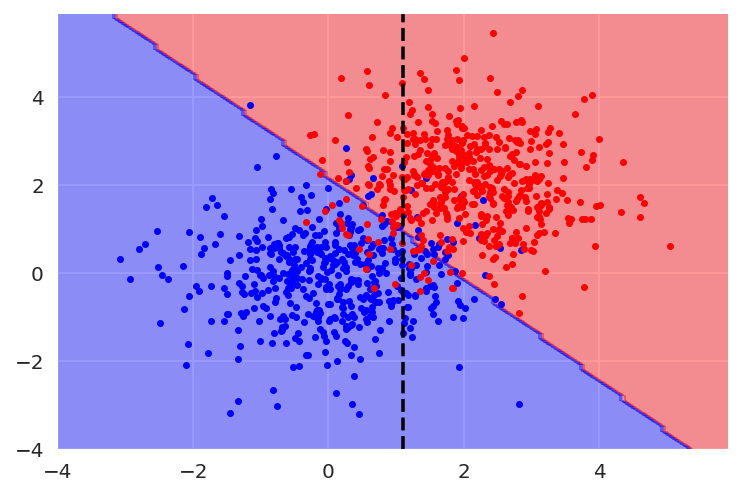

In [21]:
from matplotlib.colors import ListedColormap

xx1, xx2 = np.meshgrid(np.arange(-4, 6, .1), np.arange(-4, 6, .1))

Z = log_reg_2d.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
Z = Z.reshape(xx1.shape)

cut_1d = np.arange(-4, 6, .1)[log_reg_1d.predict_proba(np.atleast_2d(np.arange(-4,6,.1)).T)[:, 0] > .5][0]

colors = ('red', 'blue')
cmap = ListedColormap(colors)

plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
plt.plot(x1[y], x2[y], 'b.')
plt.plot(x1[~y], x2[~y], 'r.')
plt.axvline(cut_1d, color='k', linestyle='--');

However, as we increase the dimensionality of our data by adding more features, the data gets more spread out. If the data is very high dimensional, it may be too spread out to identify any trends or clusters. This is know as the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). As we increase the number of features, we will generally require more observations to ensure good sampling density throughout feature space.

## Feature importance and selection

To avoid the curse of dimensionality, we'll sometimes want to reduce the dimensionality of our data. We may also want to reduce the dimensionality of our data simply to compress it (in the case of very large data) or simply to visualize the data. Reducing dimensionality also helps make models more interpretable. When reducing the dimensionality of the data, we will want to get rid of irrelevant or redundant features.

There are a number of ways to assess feature importance. Let's work again with the California housing data set.

In [22]:
!wget http://dataincubator-wqu.s3.amazonaws.com/caldata/cal_housing.pkz -nc -P ~/scikit_learn_data/

File ‘/home/jovyan/scikit_learn_data/cal_housing.pkz’ already there; not retrieving.



In [23]:
from sklearn.datasets import fetch_california_housing

cali_data = fetch_california_housing()

cali_df = pd.DataFrame(cali_data.data, columns=cali_data.feature_names)

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
import scipy.stats

X_train, X_test, y_train, y_test = train_test_split(*shuffle(cali_df, cali_data.target), test_size=0.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

model = DecisionTreeRegressor()

rs = RandomizedSearchCV(model,
                  {'max_depth': scipy.stats.binom(9, .3, loc=1),
                  'min_samples_split': scipy.stats.binom(90, .5, loc=10)},
                   cv=5,
                   n_iter=200,
                   n_jobs=4,
                   scoring='neg_mean_squared_error')

rs.fit(X_train, y_train)
print(r2_score(y_test, rs.best_estimator_.predict(scaler.transform(X_test))))

list(zip(cali_data.feature_names, rs.best_estimator_.feature_importances_))

0.694655211765728


[('MedInc', 0.6656359560274338),
 ('HouseAge', 0.041262878364296866),
 ('AveRooms', 0.0269774996626759),
 ('AveBedrms', 0.005336063753783868),
 ('Population', 0.009211482913202614),
 ('AveOccup', 0.1349671852500436),
 ('Latitude', 0.05532440618269043),
 ('Longitude', 0.061284527845873)]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(*shuffle(cali_df, cali_data.target), test_size=0.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

lin_reg = LinearRegression().fit(X_train, y_train)

print(r2_score(y_test, lin_reg.predict(scaler.transform(X_test))))

list(zip(cali_data.feature_names, abs(lin_reg.coef_) / sum(abs(lin_reg.coef_))))

0.5958163899219122


[('MedInc', 0.2534026099937284),
 ('HouseAge', 0.035174642080803314),
 ('AveRooms', 0.08432398441994361),
 ('AveBedrms', 0.09142145778178218),
 ('Population', 0.0015240562158920826),
 ('AveOccup', 0.01210760282720646),
 ('Latitude', 0.2648071995090968),
 ('Longitude', 0.2572384471715471)]

The `feature_selection` submodule of Scikit-learn provides [some useful tools](http://scikit-learn.org/stable/modules/feature_selection.html) for discarding unimportant features.

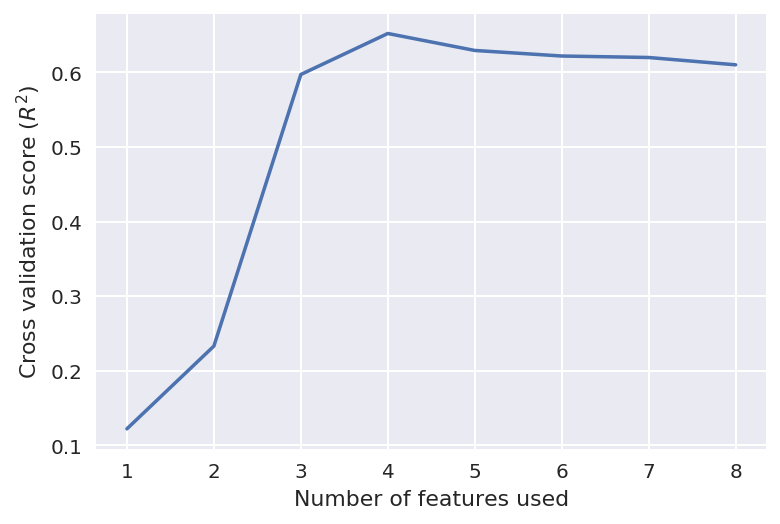

In [26]:
from sklearn.feature_selection import RFECV

feature_elimination = RFECV(estimator=model, cv=5, scoring='r2')
feature_elimination.fit(X_train, y_train)

rfecv_scores = feature_elimination.grid_scores_
plt.plot(range(1, len(rfecv_scores) + 1), rfecv_scores)
plt.xlabel('Number of features used')
plt.ylabel(r'Cross validation score ($R^2$)');

## Regularization

When we have too many features, our observations become sparse, making it hard to detect trends in the data. Our model begins to simply memorize the training set based on the many features. We can also say our model is fitting _noise_ instead of trend, because small random variations across many features results in observations being very separated.

One way to limit overfitting due to high dimensionality is _regularization_. To regularize a model, we introduce a penalty in the cost function associated with the values of model parameters themselves. For example, we could regularize our linear regression model by changing the cost function.

$$ C({\beta_i}) = \sum_j (y_j - X_{ij}\beta_i)^2 \Longrightarrow
C({\beta_i}) = \sum_j (y_j - X_{ij}\beta_i)^2 + \alpha\sum_i\beta_i^2 $$

The new cost function will tend to reduce the values of model parameters, limiting the effect of unimportant features. We could choose other penalties (e.g. $\alpha\sum_i\|\beta_i\|$) to change the effects of regularization.

In [27]:
from sklearn.linear_model import Ridge, Lasso
X_train, X_test, y_train, y_test = train_test_split(*shuffle(cali_df, cali_data.target), test_size=0.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

lin_reg = LinearRegression().fit(X_train, y_train)

alphas = np.logspace(-2, 2, 100)
ridge_coefs = []
ridge_scores = []
lasso_coefs = []
lasso_scores = []
for alpha in alphas:
    ridge_reg = Ridge(alpha=alpha).fit(X_train, y_train)
    lasso_reg = Lasso(alpha=alpha).fit(X_train, y_train)
    ridge_coefs.append(ridge_reg.coef_)
    ridge_scores.append(r2_score(y_test, ridge_reg.predict(scaler.transform(X_test))))
    lasso_coefs.append(lasso_reg.coef_)
    lasso_scores.append(r2_score(y_test, lasso_reg.predict(scaler.transform(X_test))))

lin_score = r2_score(y_test, lin_reg.predict(scaler.transform(X_test)))
print('Linear regression score: %0.2f' % lin_score)
print('Ridge regression score: %0.2f' % max(ridge_scores))
print('Lasso regression score: %0.2f' % max(lasso_scores))

Linear regression score: 0.60
Ridge regression score: 0.60
Lasso regression score: 0.59


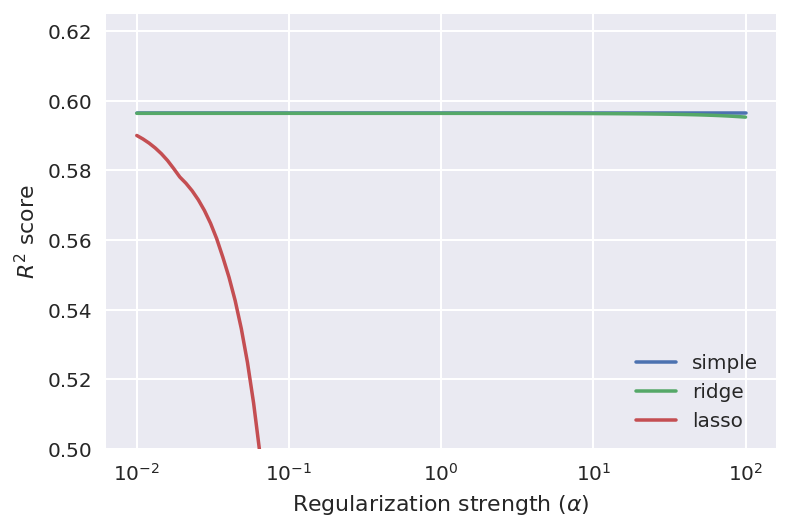

In [28]:
plt.figure()
plt.gca().set_xscale('log')
plt.gca().set_ylim([.5, .625])
plt.plot(alphas, np.repeat(lin_score, len(alphas)), label='simple')
plt.plot(alphas, ridge_scores, label='ridge')
plt.plot(alphas, lasso_scores, label='lasso')
plt.xlabel(r'Regularization strength ($\alpha$)')
plt.ylabel(r'$R^2$ score')
plt.legend();

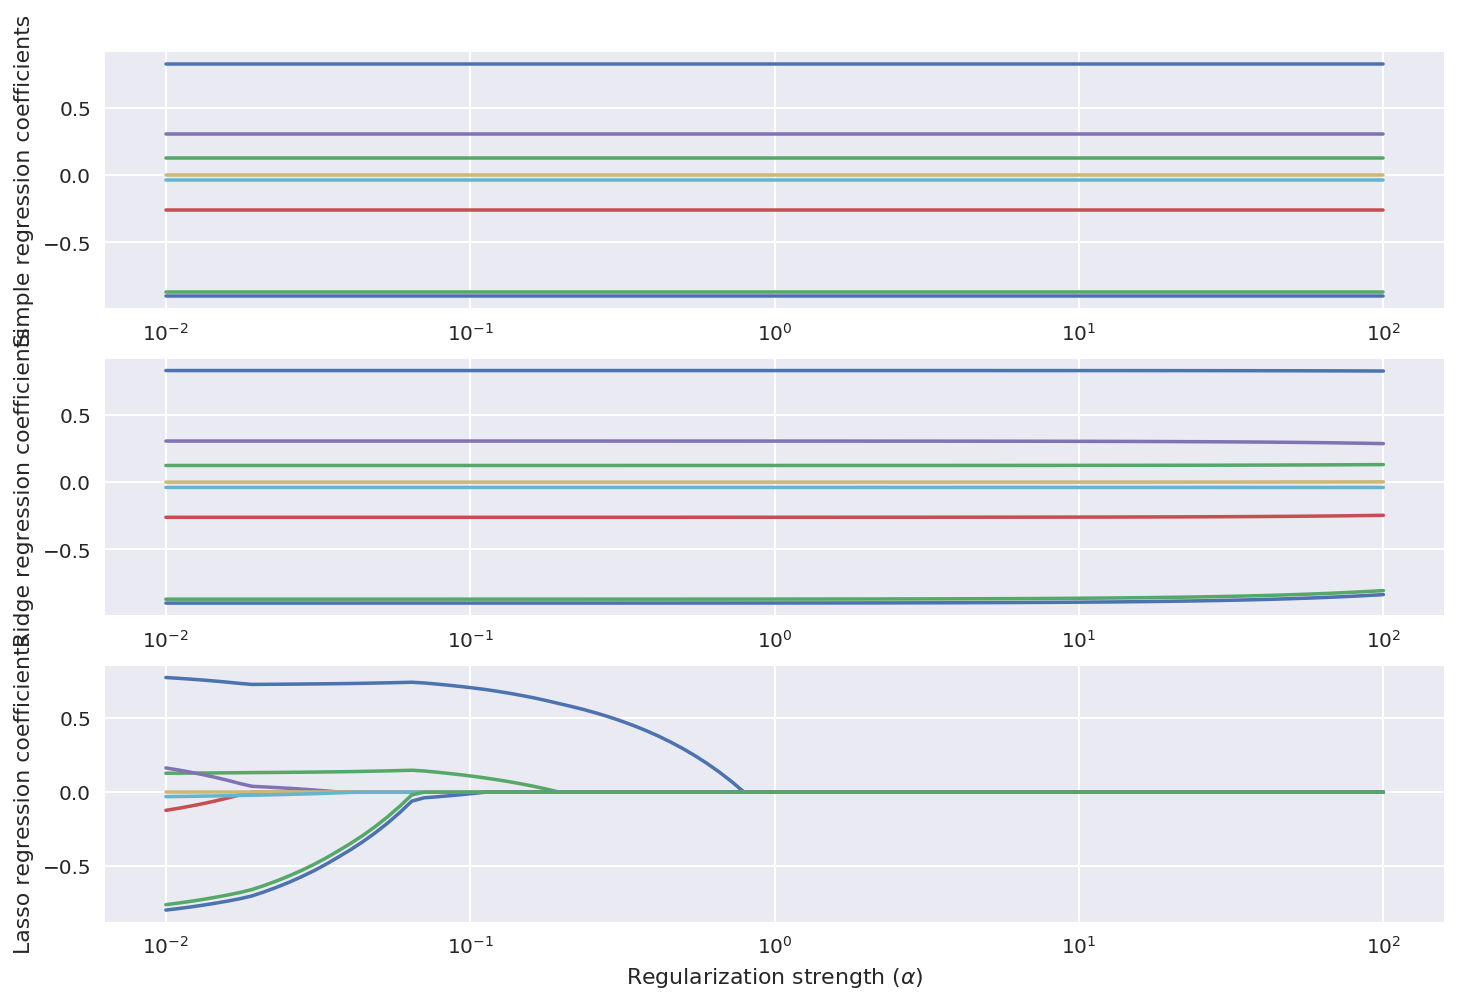

In [29]:
plt.figure(figsize=[12, 8])
plt.title('Regression coefficients')

plt.subplot(311)
plt.gca().set_xscale('log')
plt.ylabel('Simple regression coefficients')
for coef in lin_reg.coef_:
    plt.plot(alphas, np.repeat(coef, len(alphas)))

plt.subplot(312)
plt.gca().set_xscale('log')
plt.ylabel('Ridge regression coefficients')
plt.plot(alphas, ridge_coefs)

plt.subplot(313)
plt.gca().set_xscale('log')
plt.ylabel('Lasso regression coefficients')
plt.xlabel(r'Regularization strength ($\alpha$)')
plt.plot(alphas, lasso_coefs);

In [30]:
x = 15
print(alphas[x], lasso_scores[x])
list(zip(cali_data.feature_names, lasso_coefs[x]))

0.040370172585965536 0.549267680890565


[('MedInc', 0.7338399089970102),
 ('HouseAge', 0.13888373108975033),
 ('AveRooms', -0.0),
 ('AveBedrms', 0.0),
 ('Population', 0.0),
 ('AveOccup', -0.0013433625874286444),
 ('Latitude', -0.3891871533634729),
 ('Longitude', -0.3470890944279244)]

## Correlation between features and multicollinearity

Sometimes our features may be closely related to other features. We can easily calculate the correlation coefficient between pairs of features.

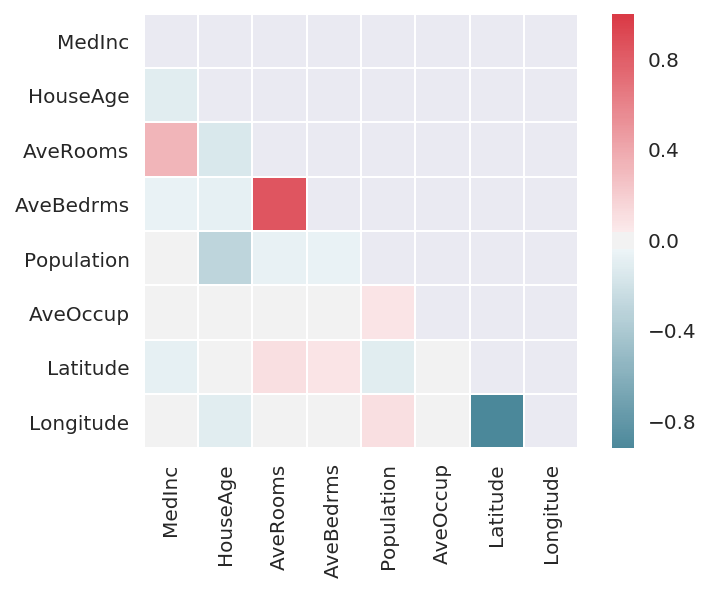

In [31]:
corr = cali_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, center=0, vmax=1);

Correlation can be an indicator of feature redundancy. In particular if a feature can be approximated as a linear combination of other features

$$ X_j \approx \sum_{i \ne j}\beta_{ij}X_i $$

we say our features are multicollinear. Multicollinearity can introduce instability into our regression model parameters, making model interpretation difficult. Furthermore, features that are linear combinations of other features are redundant.

## Principal component analysis

So far we have explored techniques for identifying unimportant or redundant features and ways to eliminate them from our data or model. When we eliminate features from our data, even if they are correlated with other features, we lose information.

One way to mitigate the loss of information is to combine our $n$ original features into $m$ new features, with $m < n$. We can calculate what combinations preserve the most information using **principal component analysis** (PCA).

Let's look back to an earlier example to understand how this works. We found earlier that adding a second feature to a data set helped us gain predictive power to separate two classes.

In [32]:
from ipywidgets import interact

def plot_data(rotation=0):
    x1_r = x1 * np.cos(rotation) + x2 * np.sin(rotation)
    x2_r = -x1 * np.sin(rotation) + x2 * np.cos(rotation)
    plt.plot(x1_r[y], x2_r[y], 'b.')
    plt.plot(x1_r[~y], x2_r[~y], 'r.')

    w1, w2 = log_reg_2d.coef_[0]
    x = np.sort(x1)
    line = (-log_reg_2d.intercept_ - w1 * x) / w2
    x_r = x * np.cos(rotation) + line * np.sin(rotation)
    line_r = -x * np.sin(rotation) + line * np.cos(rotation)
    plt.plot(x_r, line_r)
    
interact(plot_data, rotation=(0, np.pi, .1));

interactive(children=(FloatSlider(value=0.0, description='rotation', max=3.141592653589793), Output()), _dom_c…

After rotating the data, we see that we could reduce the data from two dimensions to one without losing any important information. Principal component analysis projects the data into a lower dimensional space, choosing the projection by maximizing the variance in the projected data. Usually this is the optimal choice.

In [33]:
from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test = train_test_split(np.vstack([x1, x2]).T, y)

pca = PCA(n_components=1)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

log_reg_pca = LogisticRegression(solver='lbfgs').fit(X_pca_train, y_train)

print('Score on 2D data: %0.2f' % accuracy_score(y_test, log_reg_2d.predict(X_test)))
print('Score on 1D data (PCA): %0.2f' % accuracy_score(y_test, log_reg_pca.predict(X_pca_test)))

Score on 2D data: 0.94
Score on 1D data (PCA): 0.94


## Ensemble models

We began the notebook by exploring feature extraction, which may involve applying complex algorithms to raw data to transform it into useful features for machine learning. An extension of this idea is to use machine learning models to construct features. This brings us to the idea of an _ensemble_ model, a model that uses the predictions of multiple estimators to make a final prediction.

One example of an ensemble model is the _random forest_. A random forest model trains many decision trees on random pieces of the data and averages together their predictions. In a sense, the prediction of any individual tree becomes a feature in the final prediction.

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(*shuffle(cali_df, cali_data.target), test_size=0.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [35]:
model = RandomForestRegressor(n_estimators=50)

gs = GridSearchCV(model,
                  {'max_features': np.arange(.05, 1, .05)},
                  cv=5,
                  n_jobs=4,
                  scoring='neg_mean_squared_error')

gs.fit(X_train, y_train)

model = gs.best_estimator_

print(gs.best_params_)
print(r2_score(y_test, model.predict(scaler.transform(X_test))))

{'max_features': 0.45}
0.8007572324642761


In [36]:
gs = GridSearchCV(model,
                  {'min_samples_leaf': np.arange(1, 50, 5)},
                  cv=5,
                  n_jobs=4,
                  scoring='neg_mean_squared_error')

gs.fit(X_train, y_train)

model = gs.best_estimator_

print(gs.best_params_)
print(r2_score(y_test, model.predict(scaler.transform(X_test))))

{'min_samples_leaf': 1}
0.8040623107681855


In [38]:
gs = GridSearchCV(model,
                  {'n_estimators': np.arange(100, 301, 100)},
                  cv=5,
                  n_jobs=4,
                  scoring='neg_mean_squared_error')

gs.fit(X_train, y_train)

model = gs.best_estimator_

print(gs.best_params_)
print(r2_score(y_test, model.predict(scaler.transform(X_test))))

exception calling callback for <Future at 0x7fdd04099d30 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/python3.7/site-packages/joblib/_parallel_backends.py", line 510, in apply_async
    future = self._workers.submit(SafeFunction(func))
  File "/opt/conda/lib/

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}

### Custom ensembles

We can also create our own ensembles.

This will involve some new tools, _pipelines_ and _feature unions_. Pipelines allow us to bundle a series of transformers and estimators. Feature unions all us to bundle parallel transformers.

Remember that our ensemble is not meant to make predictions per se, but rather perform feature extraction, similar to a transformer. Therefore we need the estimators in our ensemble to implement a `transform` method instead of a `predict` method. We can make this modification using a simple custom class.

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin

class EstTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator
    
    def fit(self, X, y):
        self.estimator.fit(X, y)
        return self

    def transform(self, X):
        return np.atleast_2d(self.estimator.predict(X)).T

Now we can build a feature union that will use a decision tree regressor and a K-neighbors regressor in parallel to construct our ensemble features. Our pipeline will scale our raw features, pass them to the ensemble, and then make a final prediction using a simple linear regression to combine the ensemble predictions.

In [40]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(*shuffle(cali_df, cali_data.target), test_size=0.1)

knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

gs = GridSearchCV(knn,
                  {'knn__n_neighbors': range(5, 26, 5)},
                  cv=5,
                  n_jobs=4,
                  scoring='neg_mean_squared_error')

gs.fit(X_train, y_train)
print(gs.best_params_)
print(r2_score(y_test, gs.best_estimator_.predict(X_test)))

{'knn__n_neighbors': 10}
0.6926504921787934


In [41]:
from sklearn.pipeline import FeatureUnion

ensemble = FeatureUnion([
    ('rf', EstTransformer(DecisionTreeRegressor(max_depth=5, min_samples_split=45))),
    ('knn', EstTransformer(KNeighborsRegressor(n_neighbors=10)))
])

model = Pipeline([
    ('scaler', StandardScaler()),
    ('ensemble', ensemble),
    ('combine', LinearRegression(fit_intercept=False))
    ])

model.fit(X_train, y_train)

print(r2_score(y_test, model.predict(X_test)))

0.7121699246266215


*Copyright &copy; 2019 The Data Incubator.  All rights reserved.*